In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [4]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
import torch.optim as optim
from torch.utils import data

In [6]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [9]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [10]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## ViT

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(query)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, actf=nn.GELU):
        super(TransformerBlock, self).__init__()
        
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, int(forward_expansion * embed_size)),
            actf(),
            nn.Linear(int(forward_expansion * embed_size), embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, query):
        attention = self.attention(query, query, query, None)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [14]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts


In [15]:
class ViT_Classifier(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(__patch_size*hidden_expansion/2)*2
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"ViT Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.transformer_blocks = []
        
        f = get_factors(self.channel_dim)
        print(f)
        fi = np.abs(np.array(f) - np.sqrt(self.channel_dim)).argmin()
        
        _n_heads = f[fi]
        
        print(self.channel_dim, _n_heads)
        for i in range(num_blocks):
            L = TransformerBlock(self.channel_dim, _n_heads, 0, 2)
            self.transformer_blocks.append(L)
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        self.positional_encoding = PositionalEncoding(self.channel_dim, dropout=0)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
#         x = self.positional_encoding(x)
        x = self.transformer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [16]:
vit_mixer = ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_expansion=2.4, num_blocks=1, num_classes=10)

ViT Mixer : Channes per patch -> Initial:48 Final:114
[2, 3, 6, 19, 38, 57, 114]
114 6


In [17]:
vit_mixer

ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=114, out_features=114, bias=True)
        (keys): Linear(in_features=114, out_features=114, bias=True)
        (queries): Linear(in_features=114, out_features=114, bias=True)
        (fc_out): Linear(in_features=114, out_features=114, bias=True)
      )
      (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=114, out_features=228, bias=True)
        (1): GELU()
        (2): Linear(in_features=228, out_features=114, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (linear): Linear(in_features=7296, out_features=10, bias=T

In [18]:
vit_mixer(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 10])

#### Final Model

In [19]:
torch.manual_seed(SEED)
model = ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_expansion=2.4, num_blocks=10, num_classes=10)
model = model.to(device)

ViT Mixer : Channes per patch -> Initial:48 Final:114
[2, 3, 6, 19, 38, 57, 114]
114 6


In [20]:
model

ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=114, out_features=114, bias=True)
        (keys): Linear(in_features=114, out_features=114, bias=True)
        (queries): Linear(in_features=114, out_features=114, bias=True)
        (fc_out): Linear(in_features=114, out_features=114, bias=True)
      )
      (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=114, out_features=228, bias=True)
        (1): GELU()
        (2): Linear(in_features=228, out_features=114, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
   

In [21]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

number of params:  1130776


## Training

In [22]:
model_name = f'vit_mixer_c10_s{SEED}'
# model_name = f'vit_pe_mixer_c10_s{SEED}'

In [97]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [98]:
STAT ={'train_stat':[], 'test_stat':[]}

In [99]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [100]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [101]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [102]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|█████████████████████████████████████████████████| 1563/1563 [00:33<00:00, 47.13it/s]


[Train] 0 Loss: 1.743 | Acc: 36.854 18427/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 129.39it/s]


[Test] 0 Loss: 1.426 | Acc: 49.030 4903/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:33<00:00, 47.26it/s]


[Train] 1 Loss: 1.437 | Acc: 48.316 24158/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.26it/s]


[Test] 1 Loss: 1.283 | Acc: 54.150 5415/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:33<00:00, 46.61it/s]


[Train] 2 Loss: 1.301 | Acc: 53.048 26524/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.78it/s]


[Test] 2 Loss: 1.175 | Acc: 58.030 5803/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.10it/s]


[Train] 3 Loss: 1.191 | Acc: 57.356 28678/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.93it/s]


[Test] 3 Loss: 1.104 | Acc: 61.100 6110/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.19it/s]


[Train] 4 Loss: 1.102 | Acc: 60.796 30398/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.43it/s]


[Test] 4 Loss: 1.005 | Acc: 64.500 6450/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.30it/s]


[Train] 5 Loss: 1.041 | Acc: 62.980 31490/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.01it/s]


[Test] 5 Loss: 0.977 | Acc: 65.340 6534/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.50it/s]


[Train] 6 Loss: 0.997 | Acc: 64.548 32274/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.77it/s]


[Test] 6 Loss: 0.950 | Acc: 66.290 6629/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.39it/s]


[Train] 7 Loss: 0.951 | Acc: 66.292 33146/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.82it/s]


[Test] 7 Loss: 0.918 | Acc: 68.320 6832/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.46it/s]


[Train] 8 Loss: 0.915 | Acc: 67.584 33792/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.51it/s]


[Test] 8 Loss: 0.885 | Acc: 68.940 6894/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.34it/s]


[Train] 9 Loss: 0.879 | Acc: 68.942 34471/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 129.97it/s]


[Test] 9 Loss: 0.837 | Acc: 70.890 7089/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.67it/s]


[Train] 10 Loss: 0.844 | Acc: 70.022 35011/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 128.54it/s]


[Test] 10 Loss: 0.838 | Acc: 71.660 7166/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.13it/s]


[Train] 11 Loss: 0.812 | Acc: 71.232 35616/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.52it/s]


[Test] 11 Loss: 0.807 | Acc: 72.480 7248/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.28it/s]


[Train] 12 Loss: 0.783 | Acc: 72.152 36076/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.26it/s]


[Test] 12 Loss: 0.783 | Acc: 73.480 7348/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.56it/s]


[Train] 13 Loss: 0.760 | Acc: 72.936 36468/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.09it/s]


[Test] 13 Loss: 0.742 | Acc: 74.060 7406/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.31it/s]


[Train] 14 Loss: 0.733 | Acc: 73.970 36985/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.56it/s]


[Test] 14 Loss: 0.739 | Acc: 74.350 7435/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.19it/s]


[Train] 15 Loss: 0.717 | Acc: 74.404 37202/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.14it/s]


[Test] 15 Loss: 0.779 | Acc: 73.780 7378/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.28it/s]


[Train] 16 Loss: 0.700 | Acc: 75.112 37556/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.68it/s]


[Test] 16 Loss: 0.708 | Acc: 75.480 7548/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.94it/s]


[Train] 17 Loss: 0.678 | Acc: 75.902 37951/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.14it/s]


[Test] 17 Loss: 0.723 | Acc: 75.230 7523/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:35<00:00, 43.51it/s]


[Train] 18 Loss: 0.665 | Acc: 76.554 38277/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 126.62it/s]


[Test] 18 Loss: 0.703 | Acc: 75.700 7570/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.87it/s]


[Train] 19 Loss: 0.647 | Acc: 76.936 38468/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.34it/s]


[Test] 19 Loss: 0.681 | Acc: 76.330 7633/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.92it/s]


[Train] 20 Loss: 0.633 | Acc: 77.824 38912/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.25it/s]


[Test] 20 Loss: 0.687 | Acc: 76.620 7662/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 43.06it/s]


[Train] 21 Loss: 0.617 | Acc: 78.062 39031/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.40it/s]


[Test] 21 Loss: 0.675 | Acc: 77.010 7701/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.96it/s]


[Train] 22 Loss: 0.604 | Acc: 78.662 39331/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 128.27it/s]


[Test] 22 Loss: 0.661 | Acc: 77.400 7740/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:33<00:00, 46.61it/s]


[Train] 23 Loss: 0.591 | Acc: 79.022 39511/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.85it/s]


[Test] 23 Loss: 0.662 | Acc: 77.330 7733/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.08it/s]


[Train] 24 Loss: 0.583 | Acc: 79.352 39676/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.01it/s]


[Test] 24 Loss: 0.667 | Acc: 77.090 7709/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.73it/s]


[Train] 25 Loss: 0.571 | Acc: 79.896 39948/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.97it/s]


[Test] 25 Loss: 0.665 | Acc: 77.390 7739/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.38it/s]


[Train] 26 Loss: 0.563 | Acc: 80.002 40001/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.82it/s]


[Test] 26 Loss: 0.652 | Acc: 77.450 7745/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.47it/s]


[Train] 27 Loss: 0.547 | Acc: 80.650 40325/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.31it/s]


[Test] 27 Loss: 0.649 | Acc: 77.930 7793/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.78it/s]


[Train] 28 Loss: 0.538 | Acc: 80.804 40402/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.71it/s]


[Test] 28 Loss: 0.625 | Acc: 79.220 7922/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.74it/s]


[Train] 29 Loss: 0.528 | Acc: 81.290 40645/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.01it/s]


[Test] 29 Loss: 0.635 | Acc: 78.920 7892/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.20it/s]


[Train] 30 Loss: 0.519 | Acc: 81.498 40749/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.57it/s]


[Test] 30 Loss: 0.637 | Acc: 78.670 7867/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.80it/s]


[Train] 31 Loss: 0.503 | Acc: 81.884 40942/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.87it/s]


[Test] 31 Loss: 0.637 | Acc: 78.490 7849/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.53it/s]


[Train] 32 Loss: 0.496 | Acc: 82.450 41225/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.55it/s]


[Test] 32 Loss: 0.679 | Acc: 77.670 7767/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.22it/s]


[Train] 33 Loss: 0.491 | Acc: 82.652 41326/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.12it/s]


[Test] 33 Loss: 0.636 | Acc: 79.280 7928/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.38it/s]


[Train] 34 Loss: 0.479 | Acc: 82.940 41470/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.08it/s]


[Test] 34 Loss: 0.626 | Acc: 79.520 7952/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.62it/s]


[Train] 35 Loss: 0.466 | Acc: 83.480 41740/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.81it/s]


[Test] 35 Loss: 0.634 | Acc: 79.530 7953/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.26it/s]


[Train] 36 Loss: 0.460 | Acc: 83.820 41910/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.90it/s]


[Test] 36 Loss: 0.649 | Acc: 79.100 7910/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.76it/s]


[Train] 37 Loss: 0.453 | Acc: 83.808 41904/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.14it/s]


[Test] 37 Loss: 0.633 | Acc: 79.290 7929/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.42it/s]


[Train] 38 Loss: 0.448 | Acc: 84.062 42031/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.82it/s]


[Test] 38 Loss: 0.621 | Acc: 79.920 7992/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.02it/s]


[Train] 39 Loss: 0.439 | Acc: 84.276 42138/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.18it/s]


[Test] 39 Loss: 0.621 | Acc: 79.750 7975/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.24it/s]


[Train] 40 Loss: 0.423 | Acc: 84.798 42399/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.29it/s]


[Test] 40 Loss: 0.647 | Acc: 79.820 7982/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.62it/s]


[Train] 41 Loss: 0.420 | Acc: 85.048 42524/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.86it/s]


[Test] 41 Loss: 0.619 | Acc: 79.650 7965/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.55it/s]


[Train] 42 Loss: 0.412 | Acc: 85.212 42606/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.98it/s]


[Test] 42 Loss: 0.636 | Acc: 79.530 7953/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.90it/s]


[Train] 43 Loss: 0.406 | Acc: 85.480 42740/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.40it/s]


[Test] 43 Loss: 0.618 | Acc: 79.970 7997/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.43it/s]


[Train] 44 Loss: 0.397 | Acc: 85.906 42953/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.62it/s]


[Test] 44 Loss: 0.618 | Acc: 80.120 8012/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.35it/s]


[Train] 45 Loss: 0.389 | Acc: 85.970 42985/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.76it/s]


[Test] 45 Loss: 0.642 | Acc: 80.060 8006/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.81it/s]


[Train] 46 Loss: 0.382 | Acc: 86.312 43156/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.87it/s]


[Test] 46 Loss: 0.642 | Acc: 79.890 7989/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.43it/s]


[Train] 47 Loss: 0.374 | Acc: 86.636 43318/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.11it/s]


[Test] 47 Loss: 0.644 | Acc: 80.220 8022/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.54it/s]


[Train] 48 Loss: 0.367 | Acc: 86.884 43442/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.36it/s]


[Test] 48 Loss: 0.625 | Acc: 80.250 8025/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.61it/s]


[Train] 49 Loss: 0.358 | Acc: 87.116 43558/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.21it/s]


[Test] 49 Loss: 0.647 | Acc: 79.520 7952/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.27it/s]


[Train] 50 Loss: 0.352 | Acc: 87.368 43684/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.21it/s]


[Test] 50 Loss: 0.639 | Acc: 80.210 8021/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.50it/s]


[Train] 51 Loss: 0.342 | Acc: 87.640 43820/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.76it/s]


[Test] 51 Loss: 0.650 | Acc: 80.520 8052/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.85it/s]


[Train] 52 Loss: 0.338 | Acc: 87.818 43909/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.66it/s]


[Test] 52 Loss: 0.659 | Acc: 79.910 7991/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.04it/s]


[Train] 53 Loss: 0.331 | Acc: 88.086 44043/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.08it/s]


[Test] 53 Loss: 0.677 | Acc: 80.030 8003/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.26it/s]


[Train] 54 Loss: 0.325 | Acc: 88.206 44103/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.16it/s]


[Test] 54 Loss: 0.667 | Acc: 80.400 8040/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.25it/s]


[Train] 55 Loss: 0.316 | Acc: 88.680 44340/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.22it/s]


[Test] 55 Loss: 0.658 | Acc: 80.320 8032/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.63it/s]


[Train] 56 Loss: 0.313 | Acc: 88.698 44349/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.02it/s]


[Test] 56 Loss: 0.661 | Acc: 80.550 8055/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.86it/s]


[Train] 57 Loss: 0.310 | Acc: 88.756 44378/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.91it/s]


[Test] 57 Loss: 0.665 | Acc: 80.460 8046/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.65it/s]


[Train] 58 Loss: 0.298 | Acc: 89.314 44657/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.71it/s]


[Test] 58 Loss: 0.673 | Acc: 80.330 8033/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.84it/s]


[Train] 59 Loss: 0.290 | Acc: 89.662 44831/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.65it/s]


[Test] 59 Loss: 0.690 | Acc: 80.160 8016/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.06it/s]


[Train] 60 Loss: 0.288 | Acc: 89.744 44872/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.84it/s]


[Test] 60 Loss: 0.666 | Acc: 80.470 8047/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.13it/s]


[Train] 61 Loss: 0.280 | Acc: 89.968 44984/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.10it/s]


[Test] 61 Loss: 0.689 | Acc: 80.270 8027/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.73it/s]


[Train] 62 Loss: 0.276 | Acc: 89.956 44978/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.98it/s]


[Test] 62 Loss: 0.714 | Acc: 79.870 7987/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.03it/s]


[Train] 63 Loss: 0.268 | Acc: 90.256 45128/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.17it/s]


[Test] 63 Loss: 0.718 | Acc: 79.800 7980/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.29it/s]


[Train] 64 Loss: 0.259 | Acc: 90.612 45306/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.60it/s]


[Test] 64 Loss: 0.699 | Acc: 80.340 8034/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.77it/s]


[Train] 65 Loss: 0.255 | Acc: 90.804 45402/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.28it/s]


[Test] 65 Loss: 0.708 | Acc: 80.110 8011/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.72it/s]


[Train] 66 Loss: 0.253 | Acc: 90.962 45481/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.36it/s]


[Test] 66 Loss: 0.709 | Acc: 80.770 8077/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.56it/s]


[Train] 67 Loss: 0.248 | Acc: 90.976 45488/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.47it/s]


[Test] 67 Loss: 0.741 | Acc: 79.760 7976/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.53it/s]


[Train] 68 Loss: 0.242 | Acc: 91.138 45569/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.19it/s]


[Test] 68 Loss: 0.728 | Acc: 79.960 7996/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.34it/s]


[Train] 69 Loss: 0.233 | Acc: 91.396 45698/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.76it/s]


[Test] 69 Loss: 0.750 | Acc: 79.550 7955/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.36it/s]


[Train] 70 Loss: 0.233 | Acc: 91.448 45724/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.74it/s]


[Test] 70 Loss: 0.761 | Acc: 79.960 7996/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.24it/s]


[Train] 71 Loss: 0.227 | Acc: 91.898 45949/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.35it/s]


[Test] 71 Loss: 0.754 | Acc: 80.120 8012/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.37it/s]


[Train] 72 Loss: 0.220 | Acc: 92.064 46032/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.78it/s]


[Test] 72 Loss: 0.784 | Acc: 79.830 7983/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.61it/s]


[Train] 73 Loss: 0.212 | Acc: 92.138 46069/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.19it/s]


[Test] 73 Loss: 0.785 | Acc: 79.620 7962/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.27it/s]


[Train] 74 Loss: 0.214 | Acc: 92.308 46154/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.18it/s]


[Test] 74 Loss: 0.755 | Acc: 80.090 8009/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.28it/s]


[Train] 75 Loss: 0.209 | Acc: 92.440 46220/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.03it/s]


[Test] 75 Loss: 0.761 | Acc: 79.530 7953/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.82it/s]


[Train] 76 Loss: 0.204 | Acc: 92.580 46290/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.12it/s]


[Test] 76 Loss: 0.799 | Acc: 79.780 7978/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.99it/s]


[Train] 77 Loss: 0.195 | Acc: 92.914 46457/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.19it/s]


[Test] 77 Loss: 0.810 | Acc: 79.790 7979/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.17it/s]


[Train] 78 Loss: 0.195 | Acc: 93.010 46505/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.42it/s]


[Test] 78 Loss: 0.783 | Acc: 80.000 8000/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.50it/s]


[Train] 79 Loss: 0.190 | Acc: 93.026 46513/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.15it/s]


[Test] 79 Loss: 0.806 | Acc: 79.630 7963/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.38it/s]


[Train] 80 Loss: 0.186 | Acc: 93.242 46621/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.40it/s]


[Test] 80 Loss: 0.801 | Acc: 79.930 7993/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.34it/s]


[Train] 81 Loss: 0.179 | Acc: 93.428 46714/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.56it/s]


[Test] 81 Loss: 0.824 | Acc: 80.060 8006/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.20it/s]


[Train] 82 Loss: 0.175 | Acc: 93.736 46868/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.42it/s]


[Test] 82 Loss: 0.840 | Acc: 79.470 7947/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.10it/s]


[Train] 83 Loss: 0.172 | Acc: 93.680 46840/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.81it/s]


[Test] 83 Loss: 0.824 | Acc: 80.170 8017/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.38it/s]


[Train] 84 Loss: 0.172 | Acc: 93.730 46865/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.41it/s]


[Test] 84 Loss: 0.823 | Acc: 79.700 7970/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.73it/s]


[Train] 85 Loss: 0.167 | Acc: 93.716 46858/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.76it/s]


[Test] 85 Loss: 0.847 | Acc: 80.030 8003/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.32it/s]


[Train] 86 Loss: 0.161 | Acc: 94.164 47082/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.79it/s]


[Test] 86 Loss: 0.845 | Acc: 80.380 8038/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.56it/s]


[Train] 87 Loss: 0.155 | Acc: 94.412 47206/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.20it/s]


[Test] 87 Loss: 0.860 | Acc: 79.850 7985/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.77it/s]


[Train] 88 Loss: 0.153 | Acc: 94.442 47221/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.21it/s]


[Test] 88 Loss: 0.887 | Acc: 79.930 7993/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.65it/s]


[Train] 89 Loss: 0.147 | Acc: 94.704 47352/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.92it/s]


[Test] 89 Loss: 0.873 | Acc: 79.780 7978/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.62it/s]


[Train] 90 Loss: 0.149 | Acc: 94.646 47323/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.79it/s]


[Test] 90 Loss: 0.882 | Acc: 80.030 8003/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.05it/s]


[Train] 91 Loss: 0.143 | Acc: 94.906 47453/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.96it/s]


[Test] 91 Loss: 0.887 | Acc: 79.620 7962/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.52it/s]


[Train] 92 Loss: 0.143 | Acc: 94.856 47428/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.40it/s]


[Test] 92 Loss: 0.884 | Acc: 79.760 7976/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.25it/s]


[Train] 93 Loss: 0.138 | Acc: 95.016 47508/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.17it/s]


[Test] 93 Loss: 0.895 | Acc: 80.270 8027/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.47it/s]


[Train] 94 Loss: 0.133 | Acc: 95.270 47635/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.28it/s]


[Test] 94 Loss: 0.882 | Acc: 80.170 8017/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.65it/s]


[Train] 95 Loss: 0.135 | Acc: 95.266 47633/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.21it/s]


[Test] 95 Loss: 0.939 | Acc: 79.630 7963/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.63it/s]


[Train] 96 Loss: 0.128 | Acc: 95.344 47672/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.23it/s]


[Test] 96 Loss: 0.947 | Acc: 79.780 7978/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.77it/s]


[Train] 101 Loss: 0.112 | Acc: 95.856 47928/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.27it/s]


[Test] 101 Loss: 0.974 | Acc: 79.680 7968/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:33<00:00, 47.24it/s]


[Train] 102 Loss: 0.110 | Acc: 96.094 48047/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.99it/s]


[Test] 102 Loss: 0.985 | Acc: 79.870 7987/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.94it/s]


[Train] 103 Loss: 0.110 | Acc: 96.150 48075/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.64it/s]


[Test] 103 Loss: 0.990 | Acc: 79.730 7973/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.53it/s]


[Train] 104 Loss: 0.109 | Acc: 96.100 48050/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.91it/s]


[Test] 104 Loss: 1.000 | Acc: 79.870 7987/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.18it/s]


[Train] 105 Loss: 0.106 | Acc: 96.166 48083/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.88it/s]


[Test] 105 Loss: 0.984 | Acc: 79.880 7988/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.50it/s]


[Train] 106 Loss: 0.102 | Acc: 96.394 48197/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.59it/s]


[Test] 106 Loss: 1.004 | Acc: 79.860 7986/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.29it/s]


[Train] 107 Loss: 0.099 | Acc: 96.490 48245/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.53it/s]


[Test] 107 Loss: 0.981 | Acc: 80.110 8011/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.02it/s]


[Train] 108 Loss: 0.100 | Acc: 96.474 48237/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.90it/s]


[Test] 108 Loss: 1.004 | Acc: 80.140 8014/10000


 91%|████████████████████████████████████████████▌    | 1421/1563 [00:29<00:02, 48.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.85it/s]


[Train] 155 Loss: 0.030 | Acc: 98.988 49494/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.95it/s]


[Test] 155 Loss: 1.265 | Acc: 80.430 8043/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.18it/s]


[Train] 156 Loss: 0.030 | Acc: 98.974 49487/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.18it/s]


[Test] 156 Loss: 1.258 | Acc: 80.260 8026/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.52it/s]


[Train] 157 Loss: 0.029 | Acc: 99.050 49525/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.35it/s]


[Test] 157 Loss: 1.246 | Acc: 80.280 8028/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.07it/s]


[Train] 158 Loss: 0.030 | Acc: 98.982 49491/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.25it/s]


[Test] 158 Loss: 1.253 | Acc: 80.180 8018/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.18it/s]


[Train] 159 Loss: 0.029 | Acc: 99.048 49524/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.93it/s]


[Test] 159 Loss: 1.259 | Acc: 79.960 7996/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.08it/s]


[Train] 160 Loss: 0.028 | Acc: 99.104 49552/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.83it/s]


[Test] 160 Loss: 1.271 | Acc: 80.260 8026/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 47.73it/s]


[Train] 161 Loss: 0.029 | Acc: 99.048 49524/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.66it/s]


[Test] 161 Loss: 1.272 | Acc: 80.090 8009/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.31it/s]


[Train] 162 Loss: 0.028 | Acc: 99.074 49537/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.93it/s]


[Test] 162 Loss: 1.284 | Acc: 80.160 8016/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.15it/s]


[Train] 163 Loss: 0.027 | Acc: 99.120 49560/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.28it/s]


[Test] 163 Loss: 1.288 | Acc: 79.980 7998/10000


 36%|█████████████████▉                                | 561/1563 [00:11<00:20, 48.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [103]:
best_acc

80.77

In [23]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(82.57, 134)

In [26]:
# model.load_state_dict(checkpoint['model'])

In [27]:
model

ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=114, out_features=114, bias=True)
        (keys): Linear(in_features=114, out_features=114, bias=True)
        (queries): Linear(in_features=114, out_features=114, bias=True)
        (fc_out): Linear(in_features=114, out_features=114, bias=True)
      )
      (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=114, out_features=228, bias=True)
        (1): GELU()
        (2): Linear(in_features=228, out_features=114, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
   

In [30]:
with open(f"./output/{model_name}_data.json", 'r') as f:
    STAT = json.load(f)

In [31]:
STAT

{'train_stat': [[0, 1.642148034243117, 40.504],
  [1, 1.3360155291917304, 52.064],
  [2, 1.1738207881563532, 57.928],
  [3, 1.0729801917182888, 61.644],
  [4, 1.005956947593756, 64.344],
  [5, 0.9521961719922659, 66.352],
  [6, 0.9087982806195377, 67.856],
  [7, 0.8690093296960768, 69.41],
  [8, 0.8345030750114034, 70.37],
  [9, 0.8016621635193559, 71.708],
  [10, 0.7780294911417531, 72.384],
  [11, 0.7444572585634291, 73.708],
  [12, 0.7320323090330577, 74.372],
  [13, 0.7082787046276905, 74.866],
  [14, 0.6877045415661233, 75.868],
  [15, 0.6745444877419957, 76.356],
  [16, 0.6557341940362562, 76.69],
  [17, 0.6341310231848093, 77.694],
  [18, 0.6230318365345685, 77.974],
  [19, 0.611191966264048, 78.308],
  [20, 0.5931708391515094, 78.836],
  [21, 0.5810686818926439, 79.548],
  [22, 0.5682845912010945, 79.882],
  [23, 0.5576858631289318, 80.13],
  [24, 0.5451882216824375, 80.708],
  [25, 0.5356791370565588, 80.94],
  [26, 0.5244821695776529, 81.208],
  [27, 0.5157746530578293, 81.77

In [32]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

In [34]:
# !mkdir ./output/plots

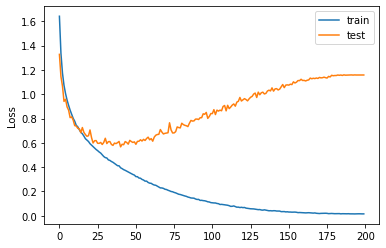

In [35]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

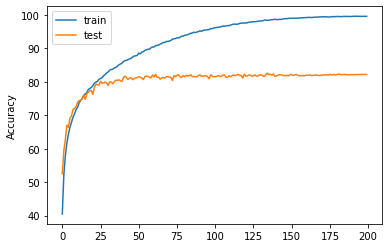

In [36]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()